In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 4090
GPU memory: 24217.31 MB


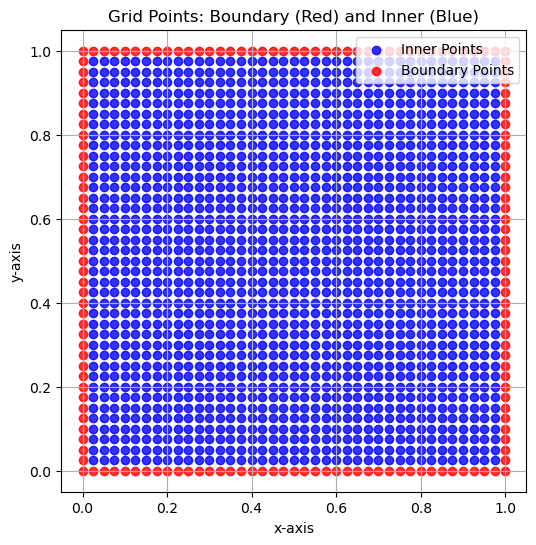

In [3]:
N = 41
x_pt = torch.zeros(N * N, 2).to(device)
for i in range(N):
    for j in range(N):
        x_pt[i * N + j, 0] = 1 * j / (N - 1) 
        x_pt[i * N + j, 1] = 1 * i / (N - 1)  

boundary_mask = (
    (x_pt[:, 0] == 0) | (x_pt[:, 0] == 1) |  
    (x_pt[:, 1] == 0) | (x_pt[:, 1] == 1)   
)
x_bd_pt = x_pt[boundary_mask] 
x_int_pt = x_pt[~boundary_mask]  

plt.figure(figsize=(6, 6))
plt.scatter(x_int_pt[:, 0].cpu(), x_int_pt[:, 1].cpu(), c='blue', label='Inner Points', alpha=0.8)
plt.scatter(x_bd_pt[:, 0].cpu(), x_bd_pt[:, 1].cpu(), c='red', label='Boundary Points', alpha=0.8)
plt.legend()
plt.title("Grid Points: Boundary (Red) and Inner (Blue)")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)
plt.show()

In [4]:
class GreenFun(nn.Module):
    def __init__(self, N, N_quadrature):     
        super(GreenFun, self).__init__()
        self.N = N
        self.N_quad = N_quadrature
        self.tau_layer = nn.Sequential(nn.Linear(1, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2))
        self.G_layer = nn.Sequential(nn.Linear(2, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2), nn.ReLU(), nn.Linear((N_quadrature - 2) ** 2, (N_quadrature - 2) ** 2))

    def forward(self, f, x, tau):    # f: (batch_size, N*N), x: (N*N, 2), tau: (batch_size, 1)
        # f = f[:, 1:-1, 1:-1].contiguous().view(-1, (self.N_quad - 2) ** 2)
        T = self.tau_layer(torch.sqrt(tau))
        G = self.G_layer(x[~boundary_mask, :])     # G is (N, N_quad) with G(i, j) = G((x_i, y_i); (x_quad_j, y_quad_j))
        output = 0 * f
        output[:, ~boundary_mask] = torch.matmul(f[:, ~boundary_mask] * T, G.t()) 
        output = output / self.N_quad 
        return output

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet(torch.nn.Module):
    def __init__(self, n_g, n_h, n_hidden, n_layers):
        super(DeepONet, self).__init__()
        self.for_tau = MLP(1, n_g, n_hidden, n_layers)
        self.for_g_1 = torch.nn.Linear(n_g, n_hidden)
        self.for_g_2 = torch.nn.Linear(n_hidden, n_h)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

## Consider the following wave equations:
$\begin{cases} u_{tt} = \Delta u , \vec x \in \Omega = [0, 1]^2 and\ t>0 \\ u(\vec x,0) = \sin(a x_1 + b x_2) , for\ \vec x = (x_1,x_2) \in \Omega \\ u_t(\vec x,0) = -\cos(a x_1 + b x_2) , for\ \vec x = (x_1,x_2) \in \Omega \\ u(\vec x,t) = \sin(a x_1 + b x_2 - t), for\ \vec x \in \partial \Omega\ and\ t >0 \end{cases}$

where $a^2 + b^2 = 1$ and the exact solution is $u(\vec x, t) = \sin(a x_1 + b x_2 - t).$

Discrete time: $t_0=0,\ t_1=\tau,\ ..., t_n=n \tau,...$

Then the $\theta$-scheme implies that $(id-\theta \tau^2 \Delta)u^{n+1} = 2 u^n - u^{n - 1} + (1 - 2 \theta) \tau ^ 2 \Delta u^n + \theta \tau^2 \Delta u^{n - 1}, n = 0, 1, 2, ...$, $\theta \in [\frac{1}{4}, \frac{1}{2}]$.

Take $\theta = \frac{1}{2}$, the scheme reads 

$$(id - \frac{\tau^2}{2} \Delta)u^{n+1} = 2 u^n - u^{n - 1} + \frac{\tau^2}{2} \Delta u^{n - 1} := F^{n + 1}$$

To avoid the instability when computing $u_{xx}$ and $u_{yy}$, we point that $F^{n+2} =  2 u^{n+1} - u^{n} + \frac{\tau^2}{2} \Delta u^{n} = 2u^{n+1} - F^n, n = 0, 1, 2, ...$. In other word, $F^0, F^1$ can be computed exactly by the known inital condition $u^0, u_t^0$ while $F^2, F^3, ...$ can be computed by this recursive relation. 

The solution $u^{n+1} (n \geq 1)$ can be obtained by:

$\begin{cases} (id - \frac{\tau^2}{2} \Delta) u^{n+1} = F^{n+1}, &\vec x \in \Omega \\ u^{n+1} = \sin(a x_1 + b x_2 - (n + 1)\tau), &\vec x \in \partial \Omega \end{cases}$

In [6]:
netF = GreenFun(N, N).to(device)
netF.load_state_dict(torch.load("../GreenNet2/net.pth", map_location = device))

<All keys matched successfully>

In [7]:
Ng = 128
netg = DeepONet(Ng * 4, Ng * 4, Ng * 4, 2).to(device)
netg.load_state_dict(torch.load("../BINet+OL2/net.pth", map_location = device))

def generate_square_points(n):
    # Boundary points per side without including corners
    boundary_spacing = np.linspace(1 / (2 * n), 1 - 1 / (2 * n), n)
    
    # Bottom boundary (x varies, y is 0)
    bottom_boundary = np.column_stack((boundary_spacing, np.zeros(n)))
    # Right boundary (x is 1, y varies)
    right_boundary = np.column_stack((np.ones(n), boundary_spacing))
    # Top boundary (x varies, y is 1)
    top_boundary = np.column_stack((boundary_spacing[::-1], np.ones(n)))
    # Left boundary (x is 0, y varies)
    left_boundary = np.column_stack((np.zeros(n), boundary_spacing[::-1]))
    
    # Combine boundary points in sequence
    boundary_points = np.vstack([bottom_boundary, right_boundary, top_boundary, left_boundary])

    t_boundary = np.zeros((len(boundary_points), 1)) 
    for i in range(len(boundary_points)):
        if(boundary_points[i,1] == 0):
            t_boundary[i] = boundary_points[i,0]
        elif(boundary_points[i,0] == 1):
            t_boundary[i] = 1 + boundary_points[i,1]
        elif(boundary_points[i,1] == 1):
            t_boundary[i] = 3 - boundary_points[i,0]
        else:
            t_boundary[i] = 4 - boundary_points[i,1]
    
    return 1 / n, t_boundary, boundary_points

taus = [1/32, 1/72, 1/128]
h, s_for_integral, x_bd_g = generate_square_points(Ng)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_g_pt = torch.from_numpy(x_bd_g).clone().float().to(device)


from scipy.special import kv, kvp

def kernel_int(tau, x, s):
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kvp(0, r / np.sqrt(tau), n=1) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (np.sqrt(tau) * r)
    return result

x_int = x_int_pt.cpu().numpy()
kernels_for_int = torch.zeros(len(taus), len(x_int), len(s_for_integral))
for k in range(len(taus)):
    for i in range(len(x_int)):
        for j in range(len(s_for_integral)):
            kernels_for_int[k, i, j] = h * kernel_int(taus[k], x_int[i, :], s_for_integral[j, 0])


def predict_u_int(net, tau, g):      # tau: scalar, g: (batch_size, 4*n_g)
    flag = 0
    for i in range(len(taus)):
        if np.abs(tau - taus[i]) < 1e-6:
            kernel = kernels_for_int[i, :, :]
            flag = 1
            # print(taus[i])
    
    if flag == 0 and tau > 0:
        kernel = torch.zeros(len(x_int), len(s_for_integral))
        for i in range(len(x_int)):
            for j in range(len(s_for_integral)):
                kernel[i, j] = h * kernel_int(tau, x_int[i, :], s_for_integral[j, 0])
    else:
        exit("The value of tau is illegal!")

    kernel = kernel.to(device)

    result = 0.5 / (np.pi) * kernel @ net(tau, g).T
    return result.T

In [8]:
M = 10000
a = np.random.uniform(0.25, 0.75, M)
b = np.sqrt(1 - a ** 2)

In [9]:
def U(t, x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    result = torch.zeros(M, x1.shape[0])
    for i in range(M):
        result[i, :] = torch.sin(a[i] * x1 + b[i] * x2 - t)
    return result.to(device)

def dU_0(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    result = torch.zeros(M, x1.shape[0])
    for i in range(M):
        result[i, :] = - torch.cos(a[i] * x1 + b[i] * x2)
    return result.to(device)

def U1(tau, x):
    return U(0, x) + tau * dU_0(x) - tau * tau / 2 * U(0, x)

def F2(tau, x):
    return 2 * U1(tau, x) - (1 + tau * tau / 2) * U(0, x) 


def computeErrors(u_exact, u_pre, printOrNot):
    if isinstance(u_exact, np.ndarray):
        u_exact = torch.from_numpy(u_exact)
    if isinstance(u_pre, np.ndarray):
        u_pre = torch.from_numpy(u_pre)
    
    error = u_exact - u_pre
    l2_norm_abs = torch.norm(error, p=2).item() / torch.sqrt(torch.tensor(error.numel(), dtype=torch.float))
    max_norm_abs = torch.norm(error, p=float('inf')).item()
    l2_norm_rel = torch.norm(error, p=2).item() / torch.norm(u_exact, p=2).item()
    max_norm_rel = torch.norm(error, p=float('inf')).item() / torch.norm(u_exact, p=float('inf')).item()  
    
    l2_norm_rel_percent = l2_norm_rel * 100
    max_norm_rel_percent = max_norm_rel * 100
    
    if printOrNot == True:
        print(f"Absolute L2 Norm Error: {l2_norm_abs:.6f}")
        print(f"Absolute Max Norm Error: {max_norm_abs:.6f}")
        print(f"Relative L2 Norm Error: {l2_norm_rel_percent:.4f}%")
        print(f"Relative Max Norm Error: {max_norm_rel_percent:.4f}%")

    return l2_norm_rel


def plotSolutions(u_exact, u_pre, N, tau, t):
    if isinstance(u_exact, torch.Tensor):
        u_exact = u_exact.cpu().detach().numpy()
    if isinstance(u_pre, torch.Tensor):
        u_pre = u_pre.cpu().detach().numpy()

    u_exact = u_exact.reshape((N, N))
    u_pre = u_pre.reshape((N, N))
    error = u_exact - u_pre
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    cax1 = axs[0].imshow(u_pre, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[0].set_title('Predicted Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(u_exact, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[1].set_title('Exact Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(np.abs(error), cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[2].set_title('Error at time ' + str(round(t, 4)) + 'with time step = ' + str(round(tau, 4)))
    fig.colorbar(cax3, ax=axs[2])

    plt.show()

In [10]:
def solveByNEKM(f, g, tau):      # f: (M, Nf*Nf), g: (M, 4*Ng) (M is the # of equations), tau is a scalar
    tau_ = torch.zeros(f.shape[0], 1) + tau
    # print(f.shape)
    # print(x_pt.shape)
    # print(tau_.shape)
    u1 = netF(f, x_pt, tau_.to(device))
    u2 = predict_u_int(netg, tau, g)
    # print(u1[:, ~boundary_mask].shape)
    # print(u2.shape)
    return u1.view(-1, N*N)[:, ~boundary_mask] + u2     # (M, n_int)


import time

def testNEKM(tau, n, warmupOrNot):
    du0 = dU_0(x_pt).view(M, -1)
    u0 = U(0, x_pt).view(M, -1)
    u1 = U1(tau, x_pt).view(M, -1)

    u_pre = U(0, x_pt).view(M, -1)
    F_even = F2(tau, x_pt)

    U_bd_g_pt_list = []
    U_bd_pt_list = []
    U_pt_list = []
    for i in range(n):
        U_bd_g_pt_list.append(U(tau * (i + 1), x_bd_g_pt).view(M, -1))
        U_bd_pt_list.append(U(tau * (i + 1), x_bd_pt).view(M, -1))
        U_pt_list.append(U(tau * (i + 1), x_pt).view(M, -1))

    start_time = time.time()

    # computeErrors(U_pt_list[0][0, :], u1[0, :], 1)

    # n + 1 = 2
    u_pre_int = solveByNEKM(F_even, U_bd_g_pt_list[1], tau * tau / 2)
    u_pre_bd = U_bd_pt_list[1]
    u_pre[:, boundary_mask] = u_pre_bd
    u_pre[:, ~boundary_mask] = u_pre_int

    # computeErrors(U_pt_list[1][0, :], u_pre[0, :], 1)

    # n + 1 = 3
    # F_odd = 2 * u_pre - u1 - tau ** 2 / 2 * (u0 + tau * du0);
    F_odd = 2 * u_pre - u1 - tau ** 2 / 2 * (1 - tau ** 2 / 2) * u0 - tau ** 3 / 2 * du0;
    u_pre_int = solveByNEKM(F_odd, U_bd_g_pt_list[2], tau * tau / 2)
    u_pre_bd = U_bd_pt_list[2]
    u_pre[:, boundary_mask] = u_pre_bd
    u_pre[:, ~boundary_mask] = u_pre_int

    # computeErrors(U_pt_list[2][0, :], u_pre[0, :], 1)
    
    for i in range(3, n):
        if (i + 1) % 2 == 0:
            F_even = 2 * u_pre - F_even
            u_pre_int = solveByNEKM(F_even, U_bd_g_pt_list[i], tau * tau / 2)
            u_pre_bd = U_bd_pt_list[i]
            u_pre[:, boundary_mask] = u_pre_bd
            u_pre[:, ~boundary_mask] = u_pre_int
            u_exact = U_pt_list[i]
        else:
            F_odd = 2 * u_pre - F_odd
            u_pre_int = solveByNEKM(F_odd, U_bd_g_pt_list[i], tau * tau / 2)
            u_pre_bd = U_bd_pt_list[i]
            u_pre[:, boundary_mask] = u_pre_bd
            u_pre[:, ~boundary_mask] = u_pre_int
            u_exact = U_pt_list[i]
        
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if warmupOrNot == False:
        random_integers = np.random.randint(0, M, 1)
        for i in random_integers:
            print('a = ', a[i], ' b = ', b[i])
            plotSolutions(u_exact[i, :], u_pre[i, :], N, tau, tau * n)
            computeErrors(u_exact[i, :], u_pre[i, :], 1)
            print('\n')
        
    
    print(f"Given the boundary conditions and initial conditions, the time to solve {M} equations simultaneously by NEKM method: {elapsed_time:.4f} s")


In [11]:
testNEKM(tau = 1 / 6, n = 12, warmupOrNot=True)

Given the boundary conditions and initial conditions, the time to solve 10000 equations simultaneously by NEKM method: 1.2479 s


In [12]:
testNEKM(tau = 1 / 6, n = 12, warmupOrNot=True)

Given the boundary conditions and initial conditions, the time to solve 10000 equations simultaneously by NEKM method: 0.1082 s


a =  0.7335141647357735  b =  0.6796741646789147


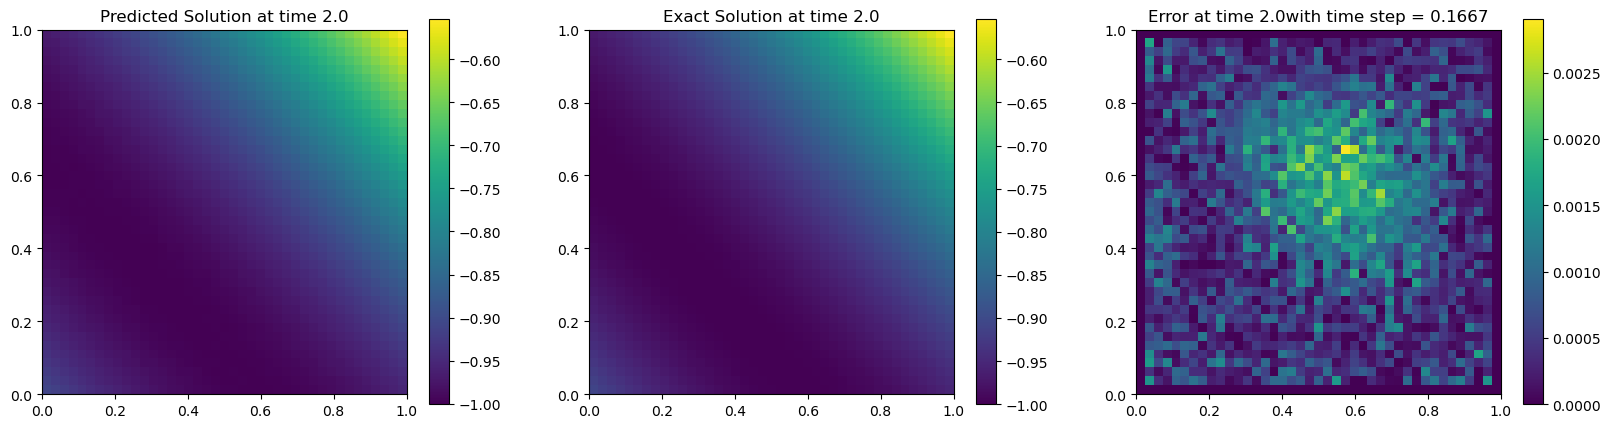

Absolute L2 Norm Error: 0.000831
Absolute Max Norm Error: 0.002900
Relative L2 Norm Error: 0.0899%
Relative Max Norm Error: 0.2900%


Given the boundary conditions and initial conditions, the time to solve 10000 equations simultaneously by NEKM method: 0.1066 s


In [13]:
testNEKM(tau = 1 / 6, n = 12, warmupOrNot=False)